In [3]:
import tensorflow as tf
import keras 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys
import random
import os                      
import numpy as np              
import pandas as pd             
import torch             
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt 
import torch.nn as nn           
from torch.utils.data import DataLoader  
from PIL import Image          
import torch.nn.functional as F 
import torchvision.transforms as transforms   
from torchvision.utils import make_grid    
from torchvision.datasets import ImageFolder  
from torch.utils.data import random_split

%matplotlib inline

In [4]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout

In [9]:
model = keras.applications.EfficientNetB4(weights='imagenet', include_top=True)

In [10]:
for layer in model.layers[0:8]:
    layer.trainable = False
    
    
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block1b_dwconv True
19 block1b_bn True
20 block1b_activation True
21 block1b_se_squeeze True
22 block1b_se_reshape True
23 block1b_se_reduce True
24 block1b_se_expand True
25 block1b_se_excite True
26 block1b_project_conv True
27 block1b_project_bn True
28 block1b_drop True
29 block1b_add True
30 block2a_expand_conv True
31 block2a_expand_bn True
32 block2a_expand_activation True
33 block2a_dwconv_pad True
34 block2a_dwconv True
35 block2a_bn True
36 block2a_activation True
37 block2a_se_squeeze True
38 block2a_se_reshape True
39 block2a_se_reduce True
40 block2a_se_exp

In [11]:
model = Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)
model.input

<KerasTensor shape=(None, 380, 380, 3), dtype=float32, sparse=None, name=keras_tensor_953>

In [13]:
x = model.output
x = Dense(3, activation='softmax')(x)
model = Model(inputs=model.input, outputs=x)

In [16]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint = ModelCheckpoint('EFNetB4-ft.keras', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [20]:
import glob
data = glob.glob('/kaggle/input/transcend/train_images/train_images/*.*')

In [24]:
data[:5]

['/kaggle/input/transcend/train_images/train_images/IMG_160.jpg',
 '/kaggle/input/transcend/train_images/train_images/IMG_21.jpg',
 '/kaggle/input/transcend/train_images/train_images/IMG_163.jpg',
 '/kaggle/input/transcend/train_images/train_images/IMG_151.jpg',
 '/kaggle/input/transcend/train_images/train_images/IMG_190.jpg']

In [33]:
ann = pd.read_csv('/kaggle/input/transcend/train_annotations.csv')
ann

,Name,State
0,IMG_1.jpg,malignant
1,IMG_2.jpg,non-nodule
2,IMG_3.jpg,non-nodule
3,IMG_4.jpg,malignant
4,IMG_5.jpg,non-nodule
...,...,...
195,IMG_196.jpg,malignant
196,IMG_197.jpg,malignant
197,IMG_198.jpg,non-nodule
198,IMG_199.jpg,malignant


In [26]:
from PIL import Image, ImageOps, ImageFilter
image = Image.open('/kaggle/input/transcend/train_images/train_images/IMG_121.jpg').convert('RGB')

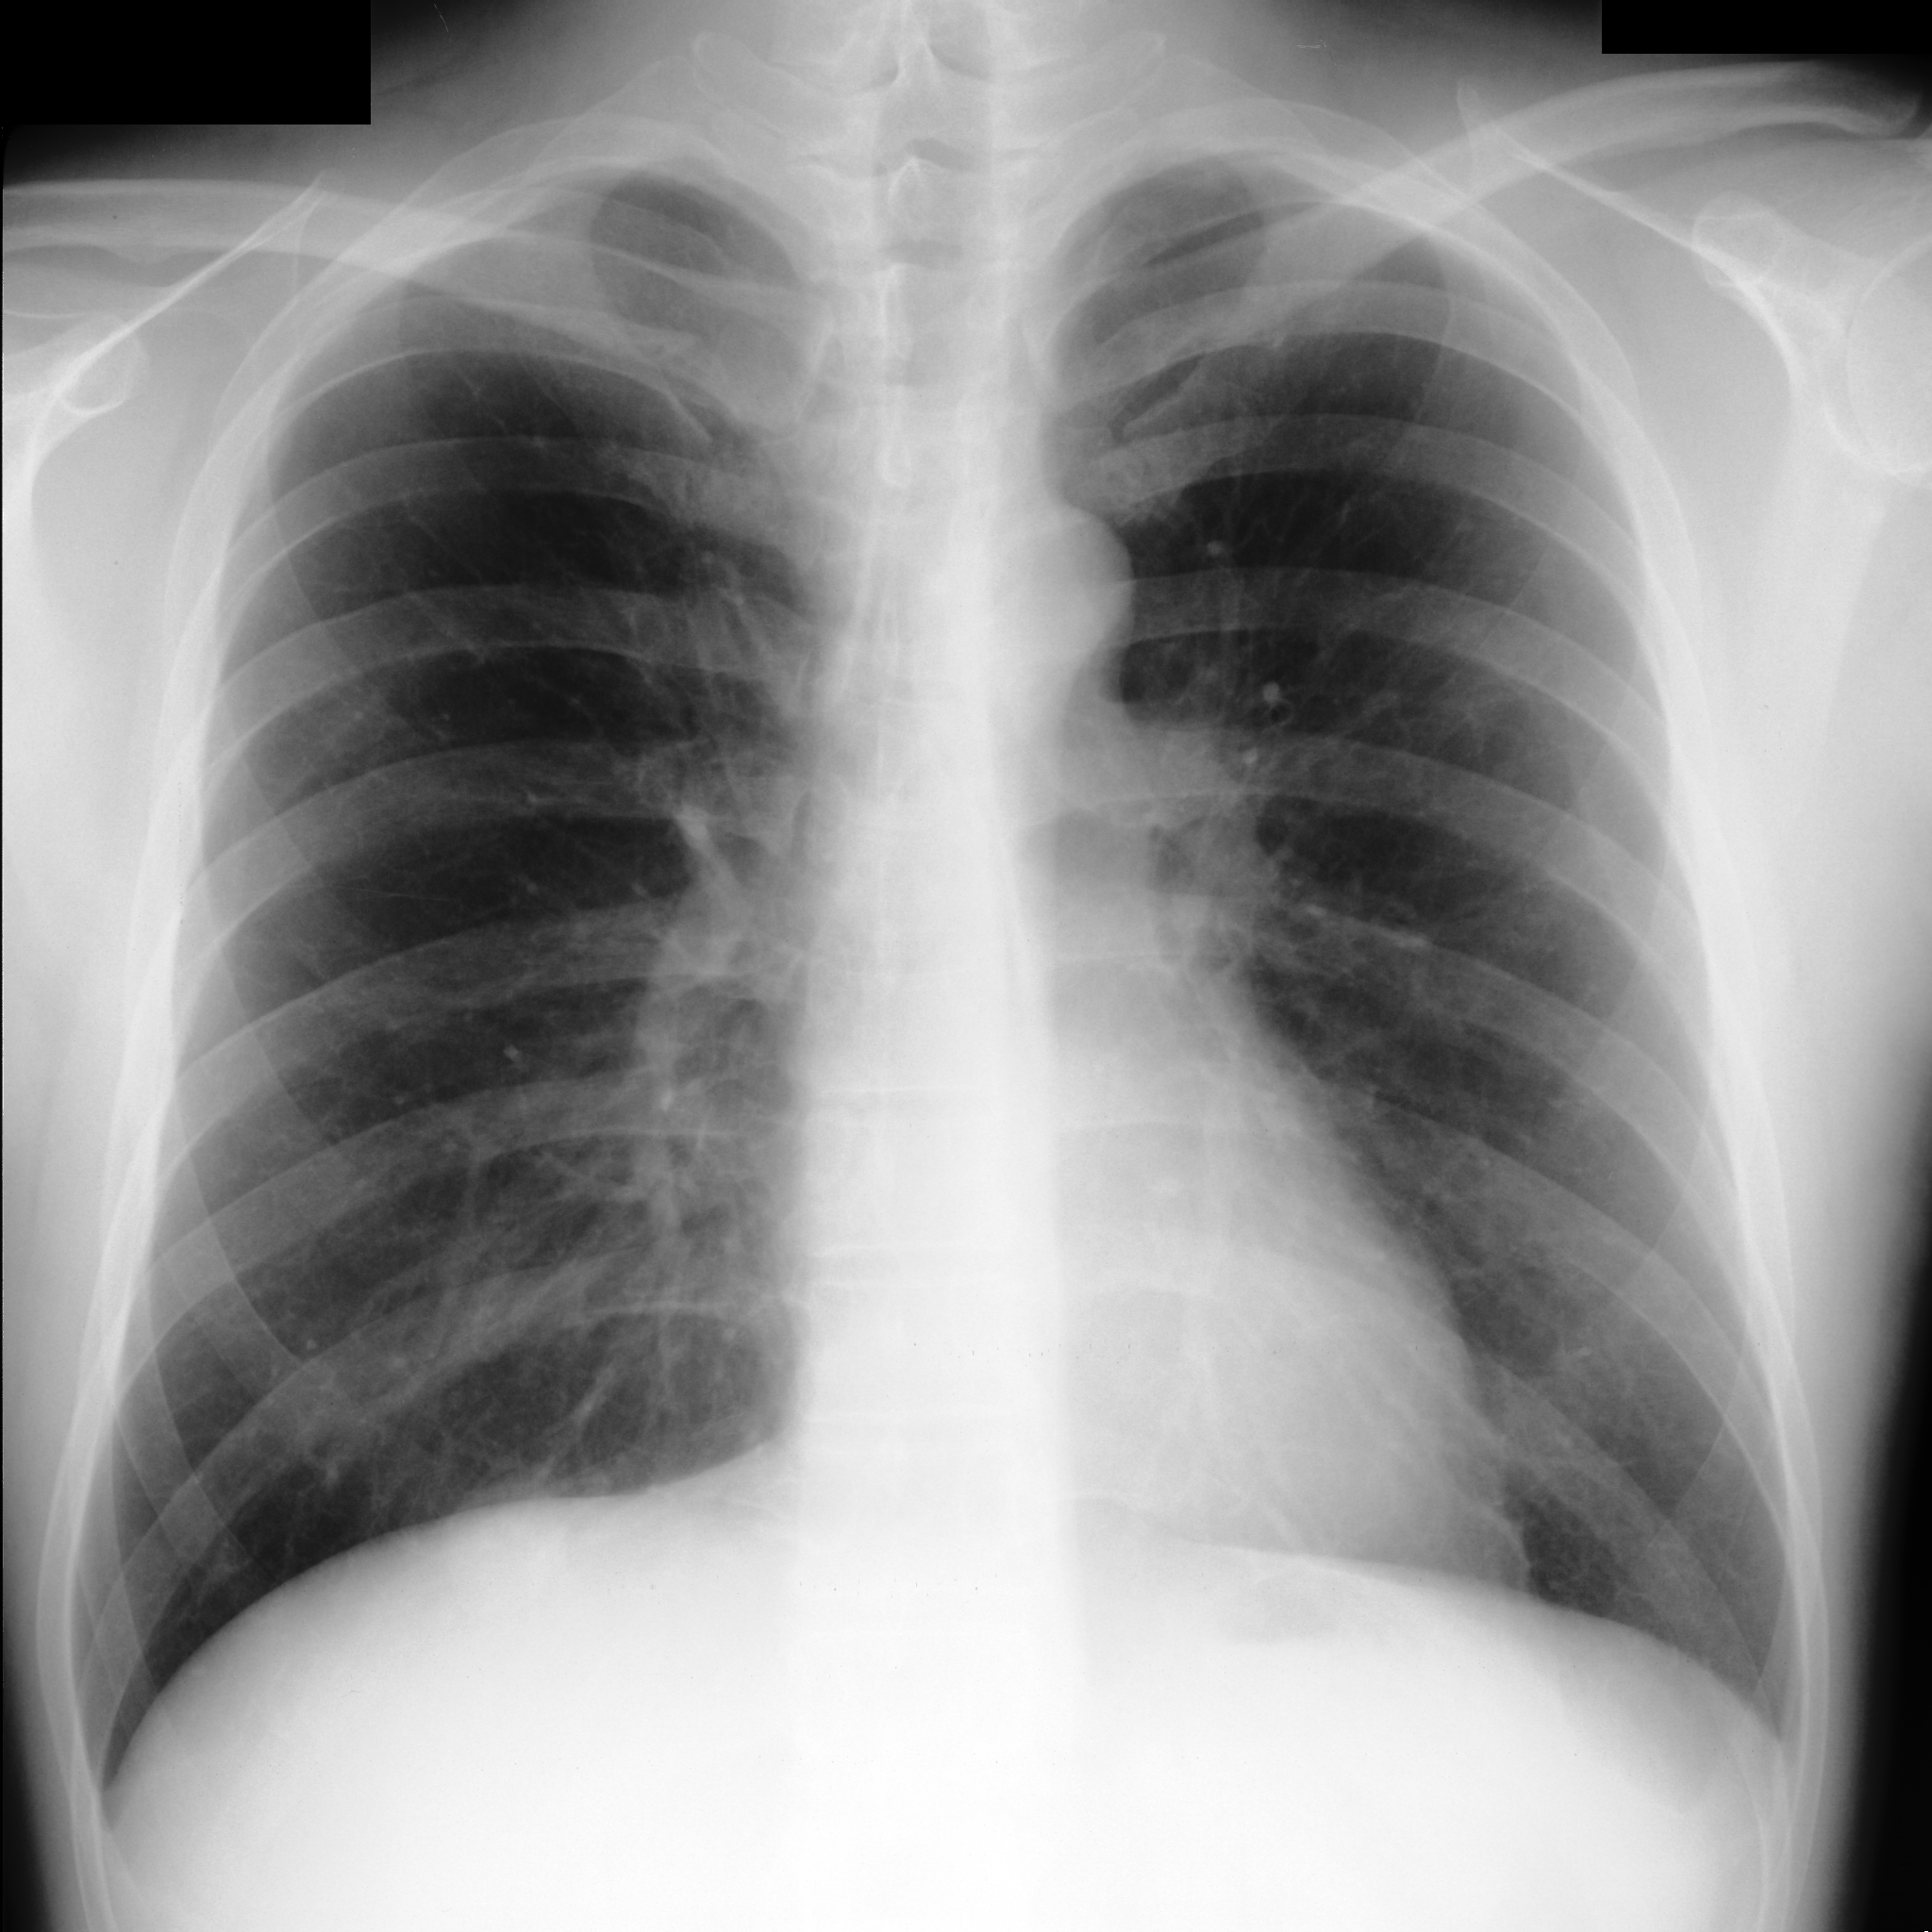

In [27]:
image

In [30]:
image.size

(2048, 2048)

In [34]:
ann['State'].replace({'benign': 0, 'non-nodule': 1, 'malignant': 2}, inplace=True)
ann

/tmp/ipykernel_35/1362740101.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ann['State'].replace({'benign': 0, 'non-nodule': 1, 'malignant': 2}, inplace=True)
/tmp/ipykernel_35/1362740101.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ann['State'].replace({'benign': 0, 'non-nodule': 1, 'ma

,Name,State
0,IMG_1.jpg,2
1,IMG_2.jpg,1
2,IMG_3.jpg,1
3,IMG_4.jpg,2
4,IMG_5.jpg,1
...,...,...
195,IMG_196.jpg,2
196,IMG_197.jpg,2
197,IMG_198.jpg,1
198,IMG_199.jpg,2


In [35]:
labels = []

for image_name in data:
    img_file_name = image_name.split('/')[-1]
    label = ann[ann['Name'] == img_file_name]['State'].values[0]
    labels.append(label)

In [44]:
from PIL import Image, ImageOps, ImageFilter
import numpy as np
import os
from sklearn.utils import shuffle

images = []

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    width, height = image.size
    pad = 380
    image = image.resize((pad, pad))
    image = image.filter(ImageFilter.SHARPEN)
    image = np.array(image)
    images.append(image)


for i in data:
    preprocess_image(i)

In [47]:
images = np.array(images)
images.shape

(200, 380, 380, 3)

In [48]:
labels= np.array(labels)

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [52]:
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizers.Adam(), metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size = 4, epochs=30, validation_data=(X_test,y_test), callbacks=[lr_reduce,checkpoint])

Epoch 1/30


I0000 00:00:1710608178.936537     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710608179.102854     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3653 - loss: 1.2880

W0000 00:00:1710608193.806108     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.32500, saving model to EFNetB4-ft.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 188s 428ms/step - accuracy: 0.3654 - loss: 1.2874 - val_accuracy: 0.3250 - val_loss: 1.0327 - learning_rate: 0.0010
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4291 - loss: 1.1328
Epoch 2: val_accuracy improved from 0.32500 to 0.42500, saving model to EFNetB4-ft.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.4314 - loss: 1.1301 - val_accuracy: 0.4250 - val_loss: 1.1035 - learning_rate: 0.0010
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4671 - loss: 1.0613
Epoch 3: val_accuracy improved from 0.42500 to 0.45000, saving model to EFNetB4-ft.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 0.4679 - loss: 1.0596 - val_accuracy: 0.4500 - val_loss: 1.2334 - learning_rate: 0.0010
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5875 - loss: 0.8963
Epoch 4: val_accuracy improved from 0.45000 to 0.475